<a href="https://colab.research.google.com/github/Kazuky1141/Colab_IA/blob/master/Funcional2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Tarea: Experimentando los Límites de MNIST (y las CNN)

Nombre: Alexis David Coaquira Quispe

Código: 2021-119081


El objetivo del presente trabajo es experimentar los límites de entrenar un modelo CNN con el conjunto de datos MNIST. Y cuánto ayuda MNIST a generalizar la clasificación de dígitos manuscritos.

##Importación de librerias

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision.io as tv_io
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import torch
import torch.nn.functional as torch_F
import torch.nn as nn
import zipfile
import os

##Descargar archivo .ZIP desde GitHub, extraer el modelo y las carpetas con las imagenes

In [ ]:
if os.path.exists("contenido.zip"):
    print("El archivo 'contenido.zip' ya existe. No se descargará nuevamente.")
else:
    os.system("wget https://github.com/Kazuky1141/Colab_IA/raw/refs/heads/master/contenido.zip")

with zipfile.ZipFile("contenido.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

##Configuración del dispositivo y clases

En esta sección configuramos el entorno para que utilice la GPU si está disponible, lo que acelera la ejecución del modelo. También definimos las clases del dataset MNIST, que representan los dígitos del 0 al 9.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = list(map(str, range(10)))

##Definición de la arquitectura CNN

Se define una red neuronal convolucional (CNN) sencilla, compuesta por dos bloques convolucionales con funciones de activación ReLU y max-pooling para reducir la dimensión de los datos. Luego, se utilizan capas completamente conectadas para la clasificación final en 10 clases. Esta estructura es típica para problemas de clasificación de imágenes como MNIST.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

##Carga del modelo

Aquí cargamos el modelo previamente entrenado desde el archivo model.pth. Se usa map_location para asegurarse de que el modelo se cargue en el dispositivo correcto (CPU o GPU). También se pone el modelo en modo evaluación con .eval() para desactivar componentes como el dropout, que solo se usan en entrenamiento.

In [ ]:
model = torch.load("model.pth", map_location=device, weights_only=False)
model.eval()

SimpleCNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

##Preprocesamiento de la imagen

Se define un conjunto de transformaciones necesarias para preparar las imágenes antes de que pasen por la red neuronal. Las imágenes se convierten a tipo float, se normalizan (escaladas de 0 a 1), se redimensionan a 28x28 píxeles (el tamaño estándar de MNIST), y se convierten a escala de grises si es necesario.



In [ ]:
IMG_WIDTH = 28
IMG_HEIGHT = 28
preprocess_trans = transforms.Compose([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.Grayscale()
])

##Función de Predicción

La función predict_digit() toma una imagen externa, la convierte a escala de grises, invierte sus colores, aplica preprocesamiento, y la envía al modelo para obtener una predicción. Luego muestra la imagen, la distribución de probabilidades, el dígito predicho con su nivel de confianza, e imprime las probabilidades por clase, permitiendo evaluar visual y numéricamente la respuesta del modelo.

In [ ]:
def predict_digit(file_path, invert_colors=False):
    # Mostrar imagen original
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))  # Cambiado de 6 a 5
    axs[0].set_title("Original")
    original_img = mpimg.imread(file_path)
    axs[0].imshow(original_img)
    axs[0].axis('off')

    # Leer y convertir a escala de grises
    image = tv_io.read_image(file_path, tv_io.ImageReadMode.GRAY)
    axs[1].set_title("Gray")
    axs[1].imshow(image.squeeze(0), cmap='gray')
    axs[1].axis('off')

    # Invertir colores
    if invert_colors:
        image = 255 - image

    # Preprocesar
    processed_image = preprocess_trans(image)
    axs[2].set_title("Inverted Color")
    axs[2].imshow(F.to_pil_image(processed_image), cmap='gray')
    axs[2].axis('off')

    # Crear batch
    batched_image = processed_image.unsqueeze(0).to(device)

    # Inferencia
    output = model(batched_image)

    # Aplicar softmax para obtener probabilidades
    probabilities = torch_F.softmax(output, dim=1)

    # Obtener la clase con mayor probabilidad
    prediction_idx = probabilities.argmax(dim=1).item()
    prediction = classes[prediction_idx]

    # Calcular el porcentaje de confianza
    confidence = probabilities[0][prediction_idx].item() * 100

    # Mostrar la distribución de probabilidad
    axs[3].set_title("Distribución de probabilidad")
    axs[3].bar(classes, probabilities.squeeze().cpu().detach().numpy())
    axs[3].set_ylim([0, 1])
    axs[3].set_ylabel('Probabilidad')

    # Mostrar dígito predicho
    axs[4].set_title(f"Predicción: {prediction} ({confidence:.2f}%)")
    axs[4].imshow(original_img)
    axs[4].axis('off')
    plt.tight_layout()
    plt.show()

    # Imprimir distribución de probabilidad y la clase con mayor probabilidad
    print(f"Distribución de probabilidad para la imagen {file_path}:")
    for idx, prob in enumerate(probabilities.squeeze().cpu().detach().numpy()):
        print(f"Clase {classes[idx]}: {prob:.4f}")
    return prediction

##Digitos a Mano

Imagen: Captura de pantalla 2025-05-01 173222.png


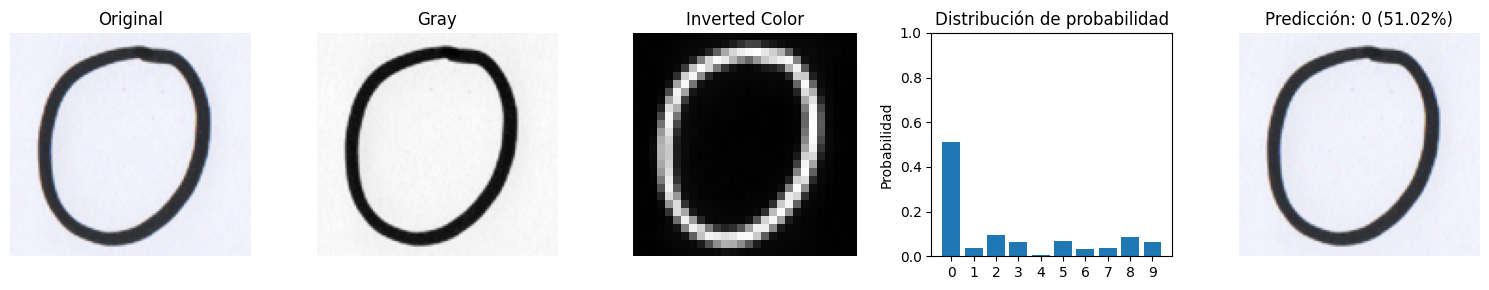

Distribución de probabilidad para la imagen /content/A_mano/Captura de pantalla 2025-05-01 173222.png:
Clase 0: 0.5102
Clase 1: 0.0356
Clase 2: 0.0958
Clase 3: 0.0645
Clase 4: 0.0063
Clase 5: 0.0692
Clase 6: 0.0335
Clase 7: 0.0382
Clase 8: 0.0846
Clase 9: 0.0621
Imagen: Captura de pantalla 2025-05-01 173315.png


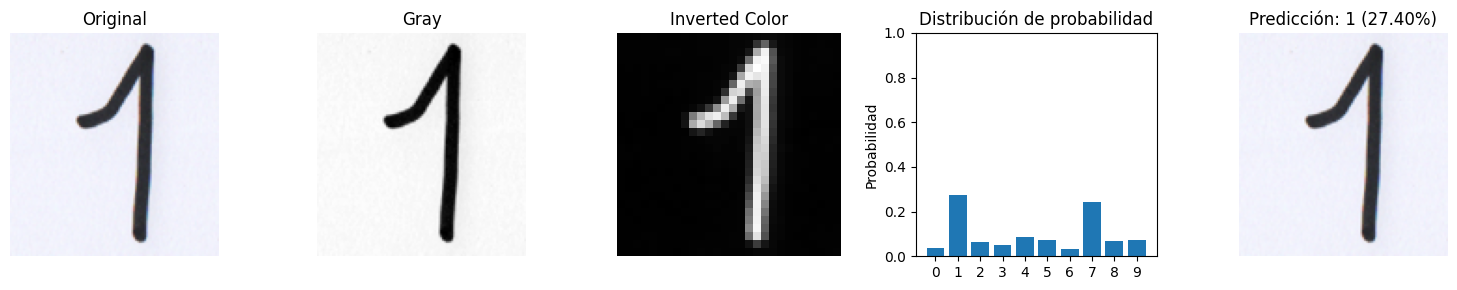

Distribución de probabilidad para la imagen /content/A_mano/Captura de pantalla 2025-05-01 173315.png:
Clase 0: 0.0390
Clase 1: 0.2740
Clase 2: 0.0631
Clase 3: 0.0525
Clase 4: 0.0852
Clase 5: 0.0710
Clase 6: 0.0318
Clase 7: 0.2445
Clase 8: 0.0669
Clase 9: 0.0721
Imagen: Captura de pantalla 2025-05-01 173318.png


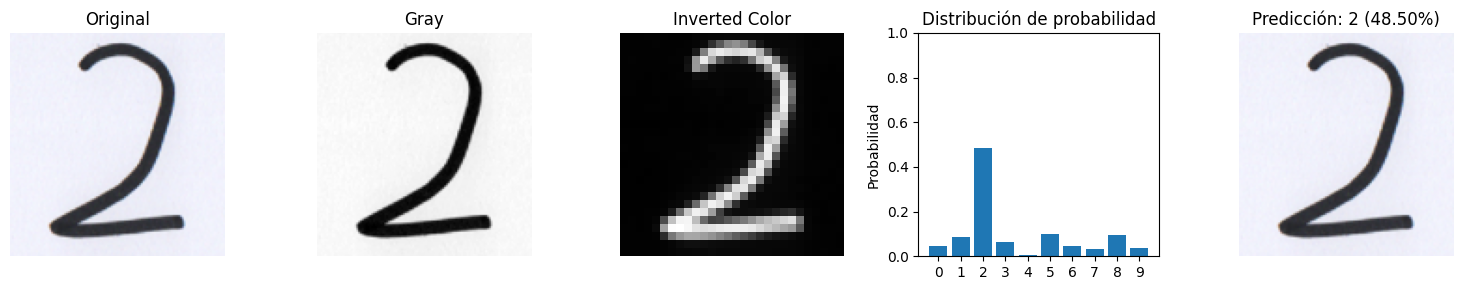

Distribución de probabilidad para la imagen /content/A_mano/Captura de pantalla 2025-05-01 173318.png:
Clase 0: 0.0482
Clase 1: 0.0879
Clase 2: 0.4850
Clase 3: 0.0631
Clase 4: 0.0052
Clase 5: 0.0997
Clase 6: 0.0445
Clase 7: 0.0339
Clase 8: 0.0949
Clase 9: 0.0376
Imagen: Captura de pantalla 2025-05-01 173322.png


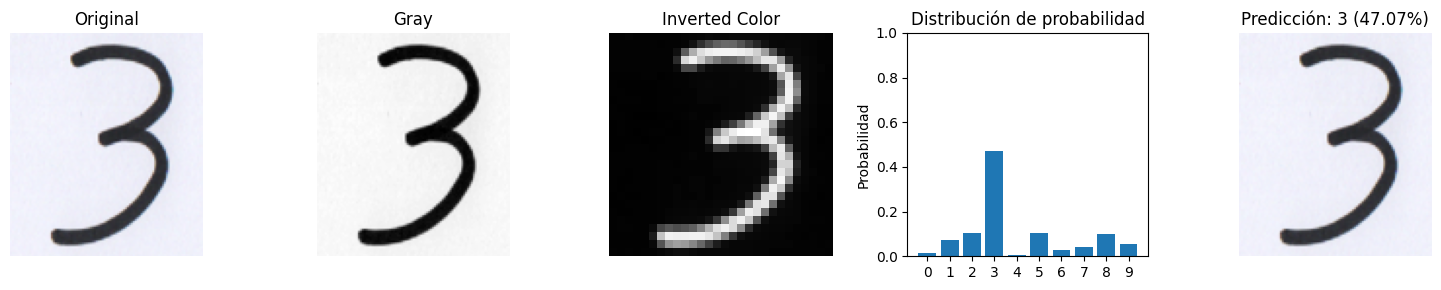

Distribución de probabilidad para la imagen /content/A_mano/Captura de pantalla 2025-05-01 173322.png:
Clase 0: 0.0147
Clase 1: 0.0729
Clase 2: 0.1053
Clase 3: 0.4707
Clase 4: 0.0057
Clase 5: 0.1061
Clase 6: 0.0274
Clase 7: 0.0436
Clase 8: 0.0995
Clase 9: 0.0540
Imagen: Captura de pantalla 2025-05-01 173326.png


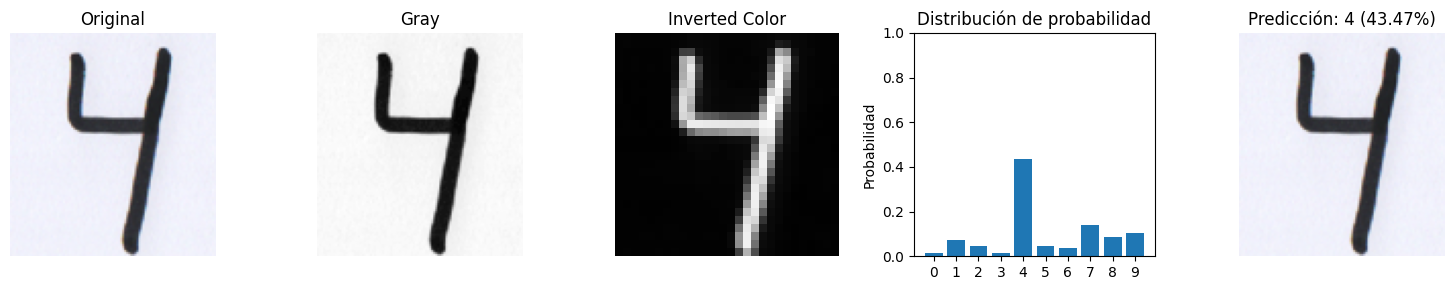

Distribución de probabilidad para la imagen /content/A_mano/Captura de pantalla 2025-05-01 173326.png:
Clase 0: 0.0126
Clase 1: 0.0730
Clase 2: 0.0471
Clase 3: 0.0166
Clase 4: 0.4347
Clase 5: 0.0473
Clase 6: 0.0374
Clase 7: 0.1400
Clase 8: 0.0866
Clase 9: 0.1048
Imagen: Captura de pantalla 2025-05-01 173330.png


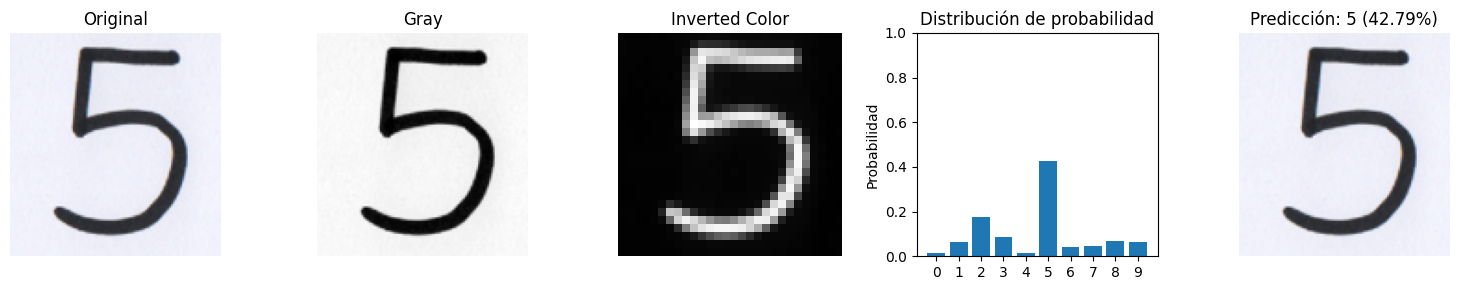

Distribución de probabilidad para la imagen /content/A_mano/Captura de pantalla 2025-05-01 173330.png:
Clase 0: 0.0147
Clase 1: 0.0628
Clase 2: 0.1759
Clase 3: 0.0885
Clase 4: 0.0127
Clase 5: 0.4279
Clase 6: 0.0403
Clase 7: 0.0450
Clase 8: 0.0669
Clase 9: 0.0654
Imagen: Captura de pantalla 2025-05-01 173334.png


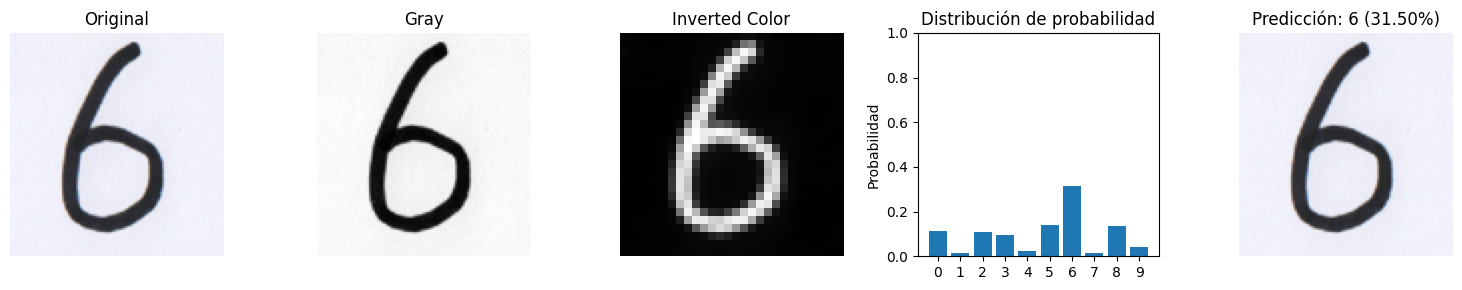

Distribución de probabilidad para la imagen /content/A_mano/Captura de pantalla 2025-05-01 173334.png:
Clase 0: 0.1118
Clase 1: 0.0143
Clase 2: 0.1094
Clase 3: 0.0964
Clase 4: 0.0251
Clase 5: 0.1393
Clase 6: 0.3150
Clase 7: 0.0132
Clase 8: 0.1357
Clase 9: 0.0398
Imagen: Captura de pantalla 2025-05-01 173338.png


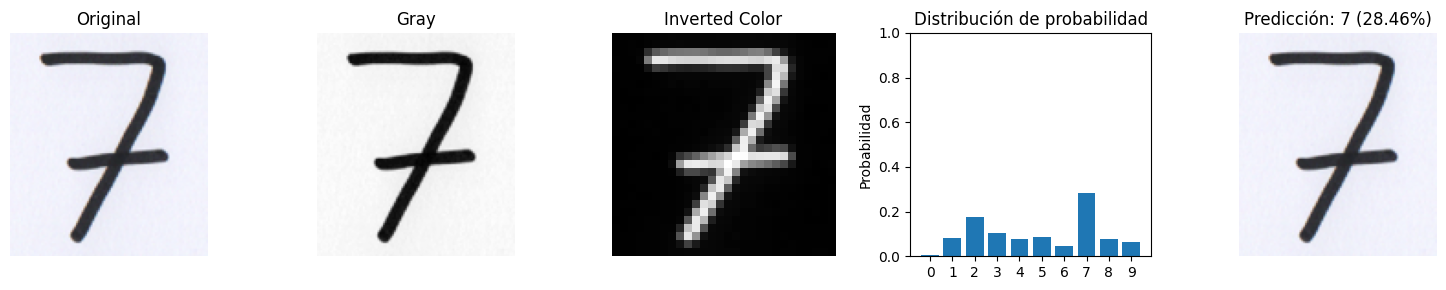

Distribución de probabilidad para la imagen /content/A_mano/Captura de pantalla 2025-05-01 173338.png:
Clase 0: 0.0059
Clase 1: 0.0823
Clase 2: 0.1766
Clase 3: 0.1042
Clase 4: 0.0773
Clase 5: 0.0858
Clase 6: 0.0445
Clase 7: 0.2846
Clase 8: 0.0763
Clase 9: 0.0626
Imagen: Captura de pantalla 2025-05-01 173342.png


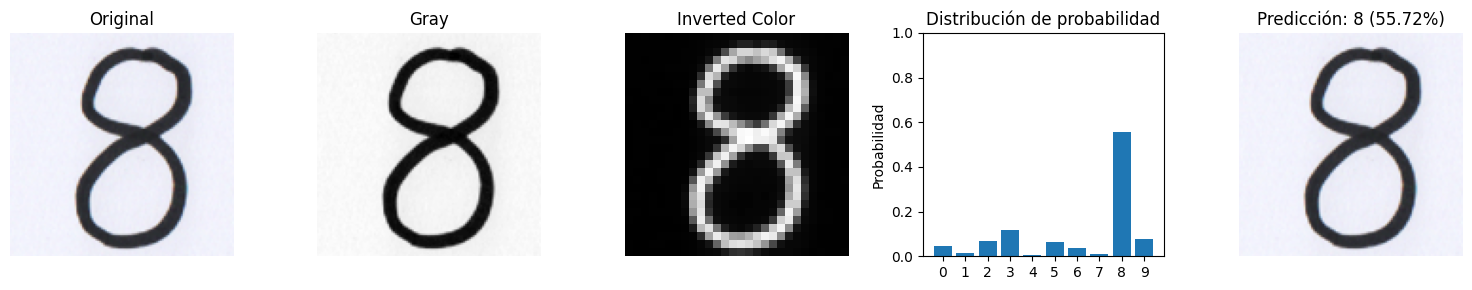

Distribución de probabilidad para la imagen /content/A_mano/Captura de pantalla 2025-05-01 173342.png:
Clase 0: 0.0469
Clase 1: 0.0139
Clase 2: 0.0680
Clase 3: 0.1195
Clase 4: 0.0066
Clase 5: 0.0630
Clase 6: 0.0364
Clase 7: 0.0115
Clase 8: 0.5572
Clase 9: 0.0769
Imagen: Captura de pantalla 2025-05-01 173345.png


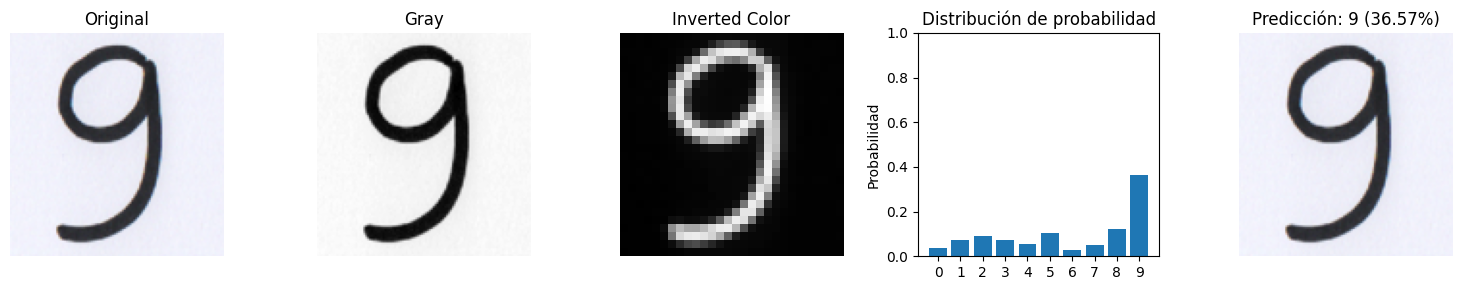

Distribución de probabilidad para la imagen /content/A_mano/Captura de pantalla 2025-05-01 173345.png:
Clase 0: 0.0372
Clase 1: 0.0710
Clase 2: 0.0888
Clase 3: 0.0746
Clase 4: 0.0552
Clase 5: 0.1029
Clase 6: 0.0298
Clase 7: 0.0518
Clase 8: 0.1229
Clase 9: 0.3657


In [ ]:
# Predecir para todas las imágenes en la carpeta
image_folder = "/content/A_mano"
for file_name in sorted(os.listdir(image_folder)):
    if file_name.endswith(".png"):
        print(f"Imagen: {file_name}")
        prediction = predict_digit(os.path.join(image_folder, file_name), invert_colors=True)

El modelo acierta correctamente en la mayoría de las predicciones, pero con variabilidad en la confianza asociada a cada predicción. Por ejemplo, el "1" se predijo correctamente con una probabilidad de 27.40%, mientras que el "8" con un 55.72%. Esto sugiere que, aunque el modelo puede identificar correctamente los dígitos, su nivel de certeza varía dependiendo de la complejidad visual de cada número. El límite aquí es que el modelo aún tiene incertidumbres, especialmente en dígitos más difíciles de distinguir, lo que implica un margen de mejora en su robustez y precisión.

##Ninguna Clase

Imagen: Captura de pantalla 2025-05-01 174807.png


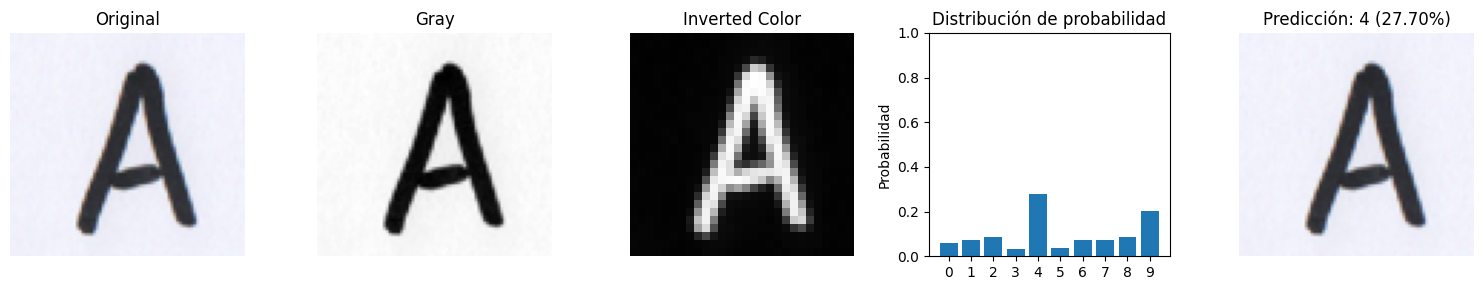

Distribución de probabilidad para la imagen /content/Ninguna_Clase/Captura de pantalla 2025-05-01 174807.png:
Clase 0: 0.0585
Clase 1: 0.0723
Clase 2: 0.0881
Clase 3: 0.0307
Clase 4: 0.2770
Clase 5: 0.0364
Clase 6: 0.0718
Clase 7: 0.0735
Clase 8: 0.0881
Clase 9: 0.2037
Imagen: Captura de pantalla 2025-05-01 174811.png


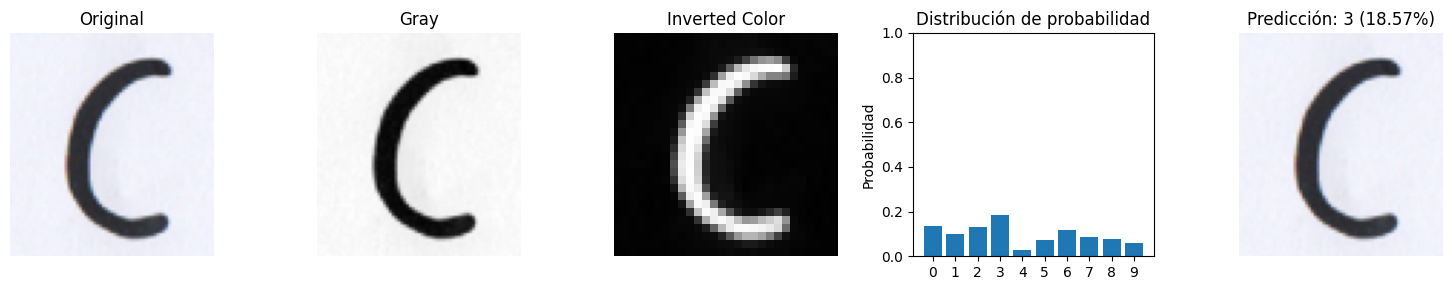

Distribución de probabilidad para la imagen /content/Ninguna_Clase/Captura de pantalla 2025-05-01 174811.png:
Clase 0: 0.1369
Clase 1: 0.1014
Clase 2: 0.1308
Clase 3: 0.1857
Clase 4: 0.0301
Clase 5: 0.0747
Clase 6: 0.1162
Clase 7: 0.0882
Clase 8: 0.0779
Clase 9: 0.0581
Imagen: Captura de pantalla 2025-05-01 174814.png


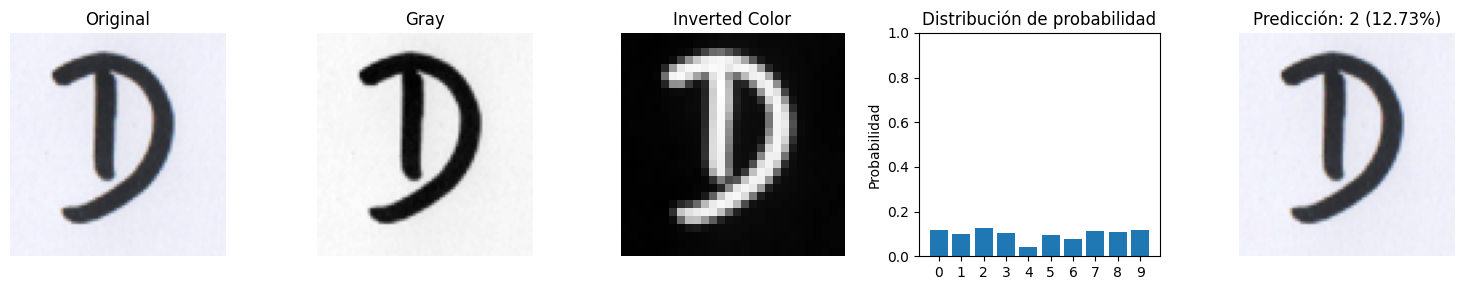

Distribución de probabilidad para la imagen /content/Ninguna_Clase/Captura de pantalla 2025-05-01 174814.png:
Clase 0: 0.1174
Clase 1: 0.1012
Clase 2: 0.1273
Clase 3: 0.1062
Clase 4: 0.0435
Clase 5: 0.0939
Clase 6: 0.0756
Clase 7: 0.1113
Clase 8: 0.1067
Clase 9: 0.1167
Imagen: Captura de pantalla 2025-05-01 174819.png


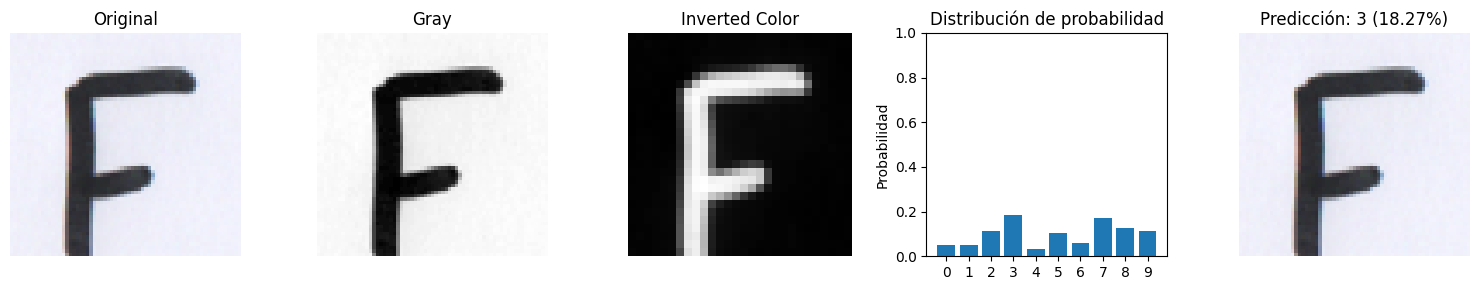

Distribución de probabilidad para la imagen /content/Ninguna_Clase/Captura de pantalla 2025-05-01 174819.png:
Clase 0: 0.0486
Clase 1: 0.0521
Clase 2: 0.1141
Clase 3: 0.1827
Clase 4: 0.0325
Clase 5: 0.1035
Clase 6: 0.0586
Clase 7: 0.1713
Clase 8: 0.1253
Clase 9: 0.1113
Imagen: Captura de pantalla 2025-05-01 174822.png


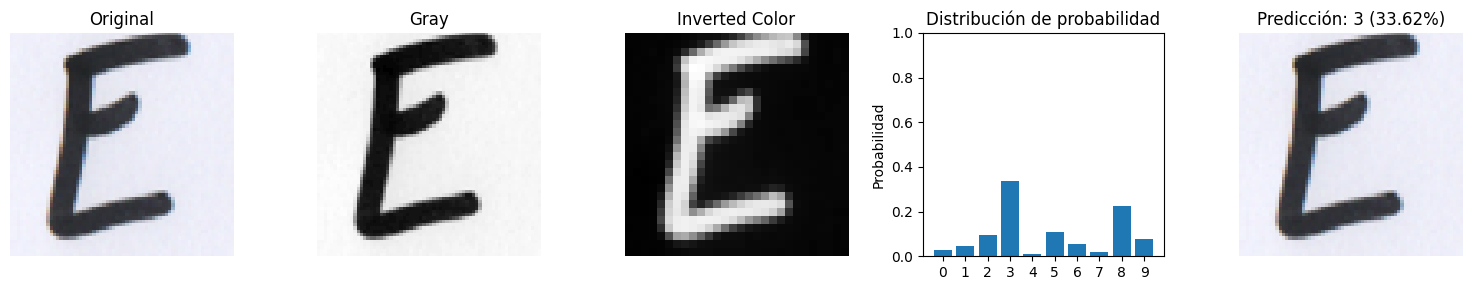

Distribución de probabilidad para la imagen /content/Ninguna_Clase/Captura de pantalla 2025-05-01 174822.png:
Clase 0: 0.0296
Clase 1: 0.0440
Clase 2: 0.0931
Clase 3: 0.3362
Clase 4: 0.0095
Clase 5: 0.1064
Clase 6: 0.0557
Clase 7: 0.0206
Clase 8: 0.2266
Clase 9: 0.0782
Imagen: Captura de pantalla 2025-05-01 174826.png


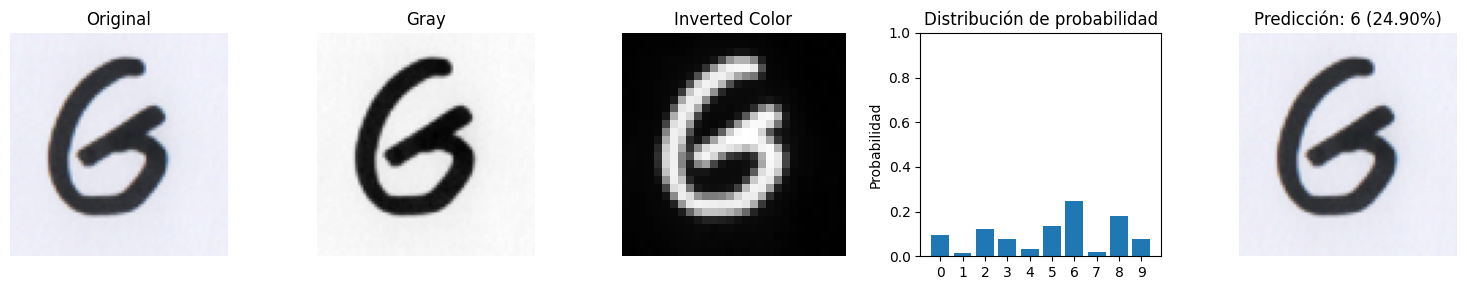

Distribución de probabilidad para la imagen /content/Ninguna_Clase/Captura de pantalla 2025-05-01 174826.png:
Clase 0: 0.0950
Clase 1: 0.0125
Clase 2: 0.1206
Clase 3: 0.0784
Clase 4: 0.0307
Clase 5: 0.1356
Clase 6: 0.2490
Clase 7: 0.0212
Clase 8: 0.1816
Clase 9: 0.0754
Imagen: Captura de pantalla 2025-05-01 174829.png


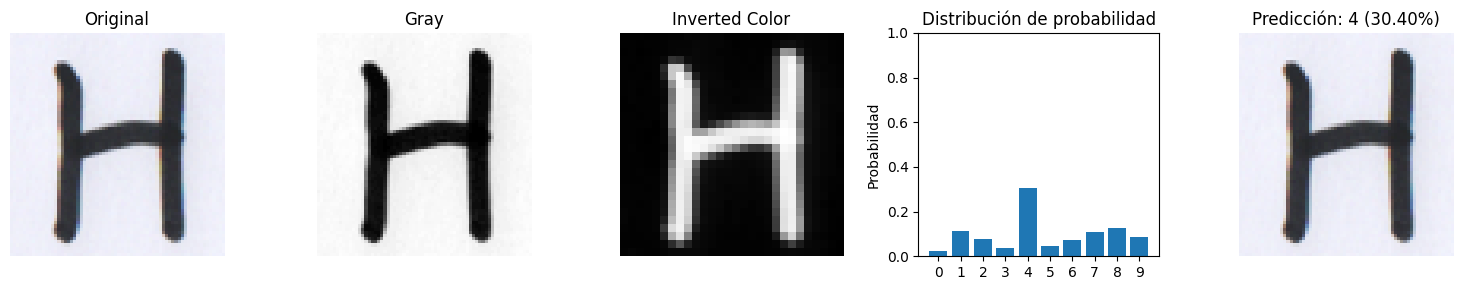

Distribución de probabilidad para la imagen /content/Ninguna_Clase/Captura de pantalla 2025-05-01 174829.png:
Clase 0: 0.0257
Clase 1: 0.1115
Clase 2: 0.0784
Clase 3: 0.0359
Clase 4: 0.3040
Clase 5: 0.0472
Clase 6: 0.0740
Clase 7: 0.1101
Clase 8: 0.1282
Clase 9: 0.0850
Imagen: Captura de pantalla 2025-05-01 174831.png


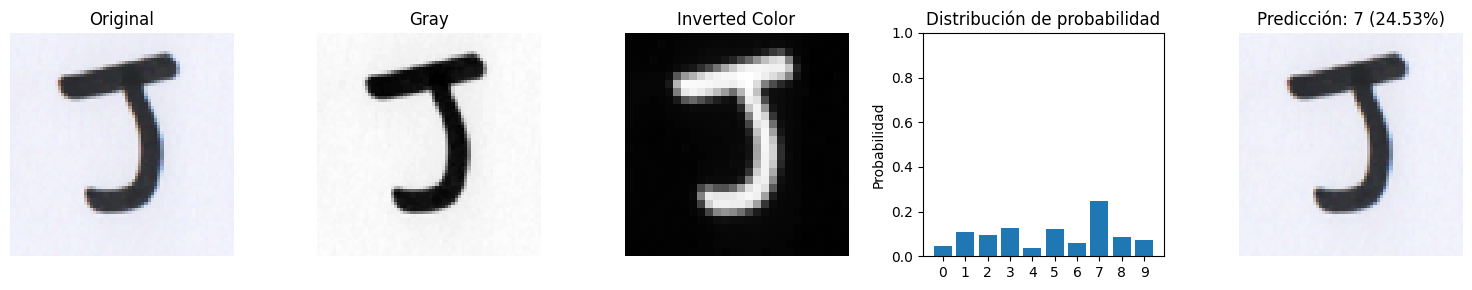

Distribución de probabilidad para la imagen /content/Ninguna_Clase/Captura de pantalla 2025-05-01 174831.png:
Clase 0: 0.0480
Clase 1: 0.1092
Clase 2: 0.0944
Clase 3: 0.1251
Clase 4: 0.0362
Clase 5: 0.1224
Clase 6: 0.0575
Clase 7: 0.2453
Clase 8: 0.0869
Clase 9: 0.0750
Imagen: Captura de pantalla 2025-05-01 174836.png


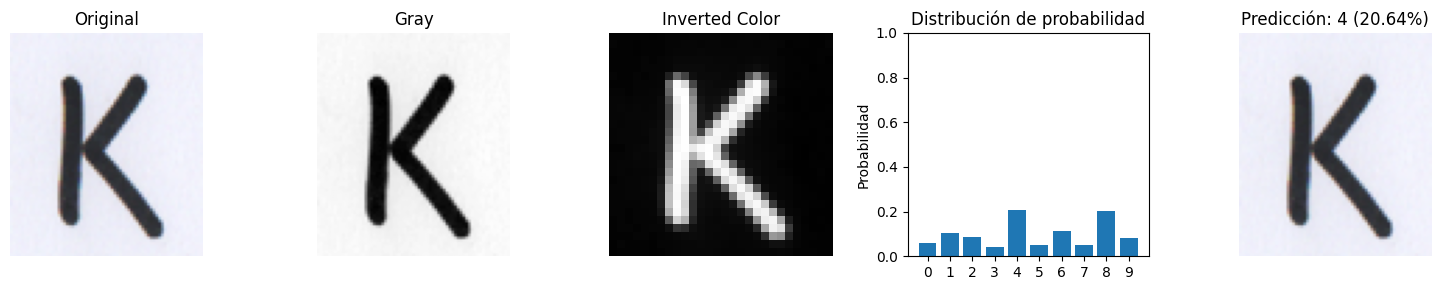

Distribución de probabilidad para la imagen /content/Ninguna_Clase/Captura de pantalla 2025-05-01 174836.png:
Clase 0: 0.0582
Clase 1: 0.1027
Clase 2: 0.0869
Clase 3: 0.0423
Clase 4: 0.2064
Clase 5: 0.0518
Clase 6: 0.1146
Clase 7: 0.0519
Clase 8: 0.2025
Clase 9: 0.0827
Imagen: Captura de pantalla 2025-05-01 174839.png


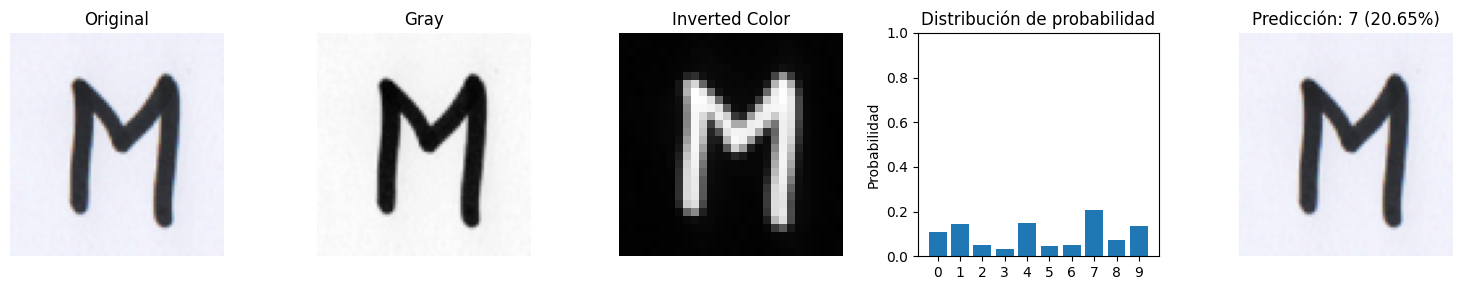

Distribución de probabilidad para la imagen /content/Ninguna_Clase/Captura de pantalla 2025-05-01 174839.png:
Clase 0: 0.1097
Clase 1: 0.1432
Clase 2: 0.0490
Clase 3: 0.0333
Clase 4: 0.1475
Clase 5: 0.0482
Clase 6: 0.0524
Clase 7: 0.2065
Clase 8: 0.0733
Clase 9: 0.1369


In [ ]:
# Predecir para todas las imágenes en la carpeta
image_folder = "/content/Ninguna_Clase"
for file_name in sorted(os.listdir(image_folder)):
    if file_name.endswith(".png"):
        print(f"Imagen: {file_name}")
        prediction = predict_digit(os.path.join(image_folder, file_name), invert_colors=True)

Al eliminar las clases o las expectativas de predicción, el modelo no tiene un marco claro para identificar los dígitos, lo que resulta en predicciones erróneas. Este experimento muestra que el modelo necesita de las clases definidas para funcionar correctamente. El límite observado es la incapacidad de realizar predicciones precisas sin las clases correctamente definidas, lo que deja en evidencia la dependencia crítica de las clases para el desempeño del modelo.



##Rotacion



Imagen: Captura de pantalla 2025-05-01 174736.png


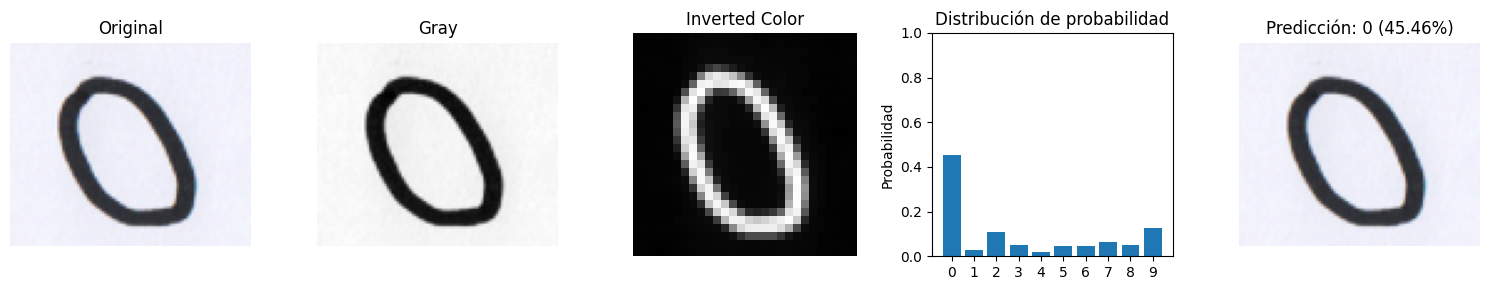

Distribución de probabilidad para la imagen /content/Rotacion/Captura de pantalla 2025-05-01 174736.png:
Clase 0: 0.4546
Clase 1: 0.0295
Clase 2: 0.1107
Clase 3: 0.0513
Clase 4: 0.0187
Clase 5: 0.0459
Clase 6: 0.0480
Clase 7: 0.0656
Clase 8: 0.0504
Clase 9: 0.1254
Imagen: Captura de pantalla 2025-05-01 174738.png


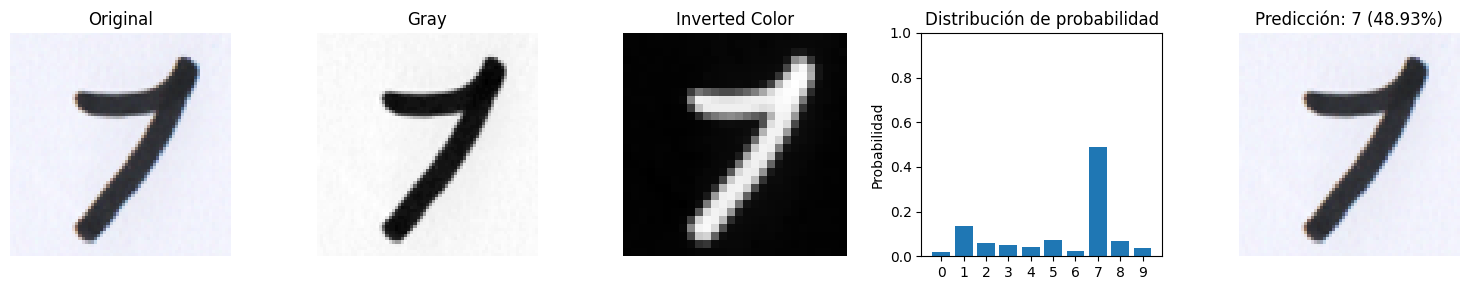

Distribución de probabilidad para la imagen /content/Rotacion/Captura de pantalla 2025-05-01 174738.png:
Clase 0: 0.0205
Clase 1: 0.1351
Clase 2: 0.0591
Clase 3: 0.0502
Clase 4: 0.0402
Clase 5: 0.0727
Clase 6: 0.0246
Clase 7: 0.4893
Clase 8: 0.0705
Clase 9: 0.0378
Imagen: Captura de pantalla 2025-05-01 174741.png


In [ ]:
# Predecir para todas las imágenes en la carpeta
image_folder = "/content/Rotacion"
for file_name in sorted(os.listdir(image_folder)):
    if file_name.endswith(".png"):
        print(f"Imagen: {file_name}")
        prediction = predict_digit(os.path.join(image_folder, file_name), invert_colors=True)

Cuando los dígitos son rotados, el modelo muestra una significativa disminución en la confianza de las predicciones. Por ejemplo, un "0" fue predicho correctamente con un 45.46%, pero el "1" fue interpretado erróneamente como "7" con un 48.93%. Este comportamiento refleja que la rotación de los números genera confusión, especialmente cuando los dígitos tienen formas similares entre sí. El límite encontrado es que el modelo no es suficientemente robusto ante transformaciones geométricas, lo que limita su precisión cuando los dígitos se presentan en diferentes orientaciones.



##Borrones

In [ ]:
# Predecir para todas las imágenes en la carpeta
image_folder = "/content/Borrones"
for file_name in sorted(os.listdir(image_folder)):
    if file_name.endswith(".png"):
        print(f"Imagen: {file_name}")
        prediction = predict_digit(os.path.join(image_folder, file_name), invert_colors=True)

Los borrones en los dígitos provocan errores significativos en la predicción del modelo. Por ejemplo, el "1" fue predicho erróneamente como un "7" con un 19.41%, y el "7" como "1" con un 14.08%. Sin embargo, el "3" fue predicho correctamente con una probabilidad del 26.44%. Los borrones generan ruido visual que afecta la capacidad del modelo para identificar correctamente los dígitos, especialmente cuando las formas son complejas o tienen similitudes con otros números. El límite observado es la alta sensibilidad del modelo a interferencias visuales, lo que disminuye la precisión en condiciones de borrones.




##Ruido

In [ ]:
# Predecir para todas las imágenes en la carpeta
image_folder = "/content/Ruido"
for file_name in sorted(os.listdir(image_folder)):
    if file_name.endswith(".png"):
        print(f"Imagen: {file_name}")
        prediction = predict_digit(os.path.join(image_folder, file_name), invert_colors=True)

La introducción de ruido en las imágenes genera confusión, como se observa cuando el "0" fue predicho como un "8" con 27.81%, el "1" como un "8" con 15.72%, y el "6" como un "8" con 24.11%. El ruido altera la claridad de las características visuales de los dígitos, lo que lleva a una mayor cantidad de predicciones erróneas. El límite aquí es que el modelo tiene dificultades para distinguir entre números con formas similares cuando el ruido distorsiona la imagen. Esto sugiere que el modelo necesita mejorar su capacidad de generalización frente a variaciones de ruido en las imágenes.



##Especiales

In [ ]:
# Predecir para todas las imágenes en la carpeta
image_folder = "/content/Especiales"
for file_name in sorted(os.listdir(image_folder)):
    if file_name.endswith(".png"):
        print(f"Imagen: {file_name}")
        prediction = predict_digit(os.path.join(image_folder, file_name), invert_colors=True)

Los caracteres especiales, como el "@" y el signo de pregunta, fueron interpretados erróneamente como números. El "@" fue predicho como un "8" con un 24.67%, y el signo de apertura de pregunta "?" fue predicho como un "5" con un 23.5%. Esto refleja que el modelo tiene dificultades para reconocer símbolos no numéricos, tratándolos como números debido a sus formas visuales similares. El límite observado es que el modelo no está entrenado para identificar caracteres especiales, lo que provoca una confusión entre símbolos y dígitos.

